# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xgboost as xgb
import pandas as pd
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format='retina'
sns.set_theme()
import shap


from metrics import compute_score, just_mAP_mRCE, pretty_evaluation
from import_data import import_data, categorical_features, timestamp_features, targets
from cross_validate import cross_validate, cv_metrics

# EDA

# Feature Engineering

In [104]:
df = import_data('../data/raw/sample_200k_rows')

In [101]:
import warnings

df = import_data('../data/raw/sample_200k_rows')

class Transformer:
    enabled_features = [
        # Tweet features
        "tweet_type",
        "language",
        "tweet_timestamp",
        # Engaged-with User (i.e., Engagee) Features
        "engaged_with_user_follower_count",
        "engaged_with_user_following_count",
        "engaged_with_user_is_verified",
        "engaged_with_user_account_creation",
        # Engaging User (i.e., Engager) Features
        "engaging_user_follower_count",
        "engaging_user_following_count",
        "engaging_user_is_verified",
        "engaging_user_account_creation",
        # Engagement features
        "engagee_follows_engager"
    ]
    
    target_encoders = {}
    count_encoders = {}
    
    def __init__(self):
        pass
    
    def fit_transform(self, train_df):
        self._timestamps_to_int(train_df)
        
        # Categorical count encoding
        for feature in categorical_features:
            new_feature = f'CE_{feature}'
            self.count_encoders[new_feature] = count_encoder = ce.CountEncoder(cols=[0])
            train_df[new_feature] = count_encoder.fit_transform(train_df[feature].cat.codes.astype(int))
            
        # Categorical target encoding
        for feature in categorical_features:
            for target in targets:
                new_feature = f'TE_{feature}__{target}'
                self.target_encoders[new_feature] = te = ce.TargetEncoder(cols=[feature])
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    train_df[new_feature] = te.fit_transform(train_df[feature], train_df[target])
        
        for feature in categorical_features:
            train_df = train_df.drop(feature, axis=1)
        
        return train_df[[f for f in train_df.columns if (
            f in self.enabled_features or
            f in self.target_encoders.keys() or
            f in self.count_encoders.keys() or
            f in [
            'tweet_timestamp__day',
            'tweet_timestamp__hour',
            'tweet_timestamp__minute',
            'tweet_timestamp__second',
        ])]]

    def transform(self, test_df):
        self._timestamps_to_int(test_df)
        
        # Categorical count encoding
        for feature in categorical_features:
            new_feature = f'CE_{feature}'
            test_df[new_feature] = self.count_encoders[new_feature].transform(test_df[feature].cat.codes.astype(int))
        
        # Categorical target encoding
        for name, te in self.target_encoders.items():
            feature = name.split('__', maxsplit=1)[0].split('_', maxsplit=1)[1]
            test_df[name] = te.transform(test_df[feature])[feature]
        
        for feature in categorical_features:
            test_df = test_df.drop(feature, axis=1)
        
        return test_df[[f for f in test_df.columns if (
            f in self.enabled_features or
            f in self.target_encoders.keys() or
            f in self.count_encoders.keys() or
            f in [
            'tweet_timestamp__day',
            'tweet_timestamp__hour',
            'tweet_timestamp__minute',
            'tweet_timestamp__second',
        ])]]
    
    def _timestamps_to_int(self, df):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            for f in timestamp_features:
                df[f] = pd.to_numeric(df[f]) // (10**9)

Transformer().fit_transform(df).dtypes

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


tweet_timestamp                             int64
engaged_with_user_follower_count            int64
engaged_with_user_following_count           int64
engaged_with_user_is_verified                bool
engaged_with_user_account_creation          int64
engaging_user_follower_count                int64
engaging_user_following_count               int64
engaging_user_is_verified                    bool
engaging_user_account_creation              int64
engagee_follows_engager                      bool
CE_language                                 int64
CE_tweet_type                               int64
CE_present_media                            int64
TE_language__reply                        float64
TE_language__retweet                      float64
TE_language__retweet_with_comment         float64
TE_language__like                         float64
TE_tweet_type__reply                      float64
TE_tweet_type__retweet                    float64
TE_tweet_type__retweet_with_comment       float64


In [102]:
%%time
params = {
    'tree_method': 'gpu_hist',
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.7,
    'min_child_weight': 10, # increase if train-test-gap is large. More conservative but less overfitting
    'max_depth': 6,
    'seed': 42
}

df = import_data('../data/raw/sample_200k_rows')
feature_engineer = Transformer()
cv_models, cv_results_train, cv_results_test = cross_validate(df, feature_engineer, params, num_boost_round=20)

print("********************* TRAIN *********************")
for metric_lst in cv_metrics(cv_results_train):
    metric_lst = np.array(metric_lst)
    print(f"LB {(metric_lst.mean() - metric_lst.std()):+.4f} to UB {(metric_lst.mean() + metric_lst.std()):+.4f} (± 1σ)")

print("********************* TEST *********************")
for metric_lst in cv_metrics(cv_results_test):
    metric_lst = np.array(metric_lst)
    print(f"LB {(metric_lst.mean() - metric_lst.std()):+.4f} to UB {(metric_lst.mean() + metric_lst.std()):+.4f} (± 1σ)")

print(params)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

********************* TRAIN *********************
LB +0.2512 to UB +0.2829 (± 1σ)
LB +9.8510 to UB +12.2820 (± 1σ)
********************* TEST *********************
LB +0.2129 to UB +0.2234 (± 1σ)
LB +5.7041 to UB +6.6163 (± 1σ)
{'tree_method': 'gpu_hist', 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'subsample': 0.7, 'min_child_weight': 10, 'max_depth': 6, 'seed': 42}
CPU times: user 18.9 s, sys: 476 ms, total: 19.3 s
Wall time: 17.6 s


# Model Training and Evaluation

What the current top leaderboard submission looks like:
```
mAP:                        0.3115
mRCE:                      16.4698
```
Leaderboard: https://recsys-twitter.com/leaderboard/all-submissions

# Model analysis

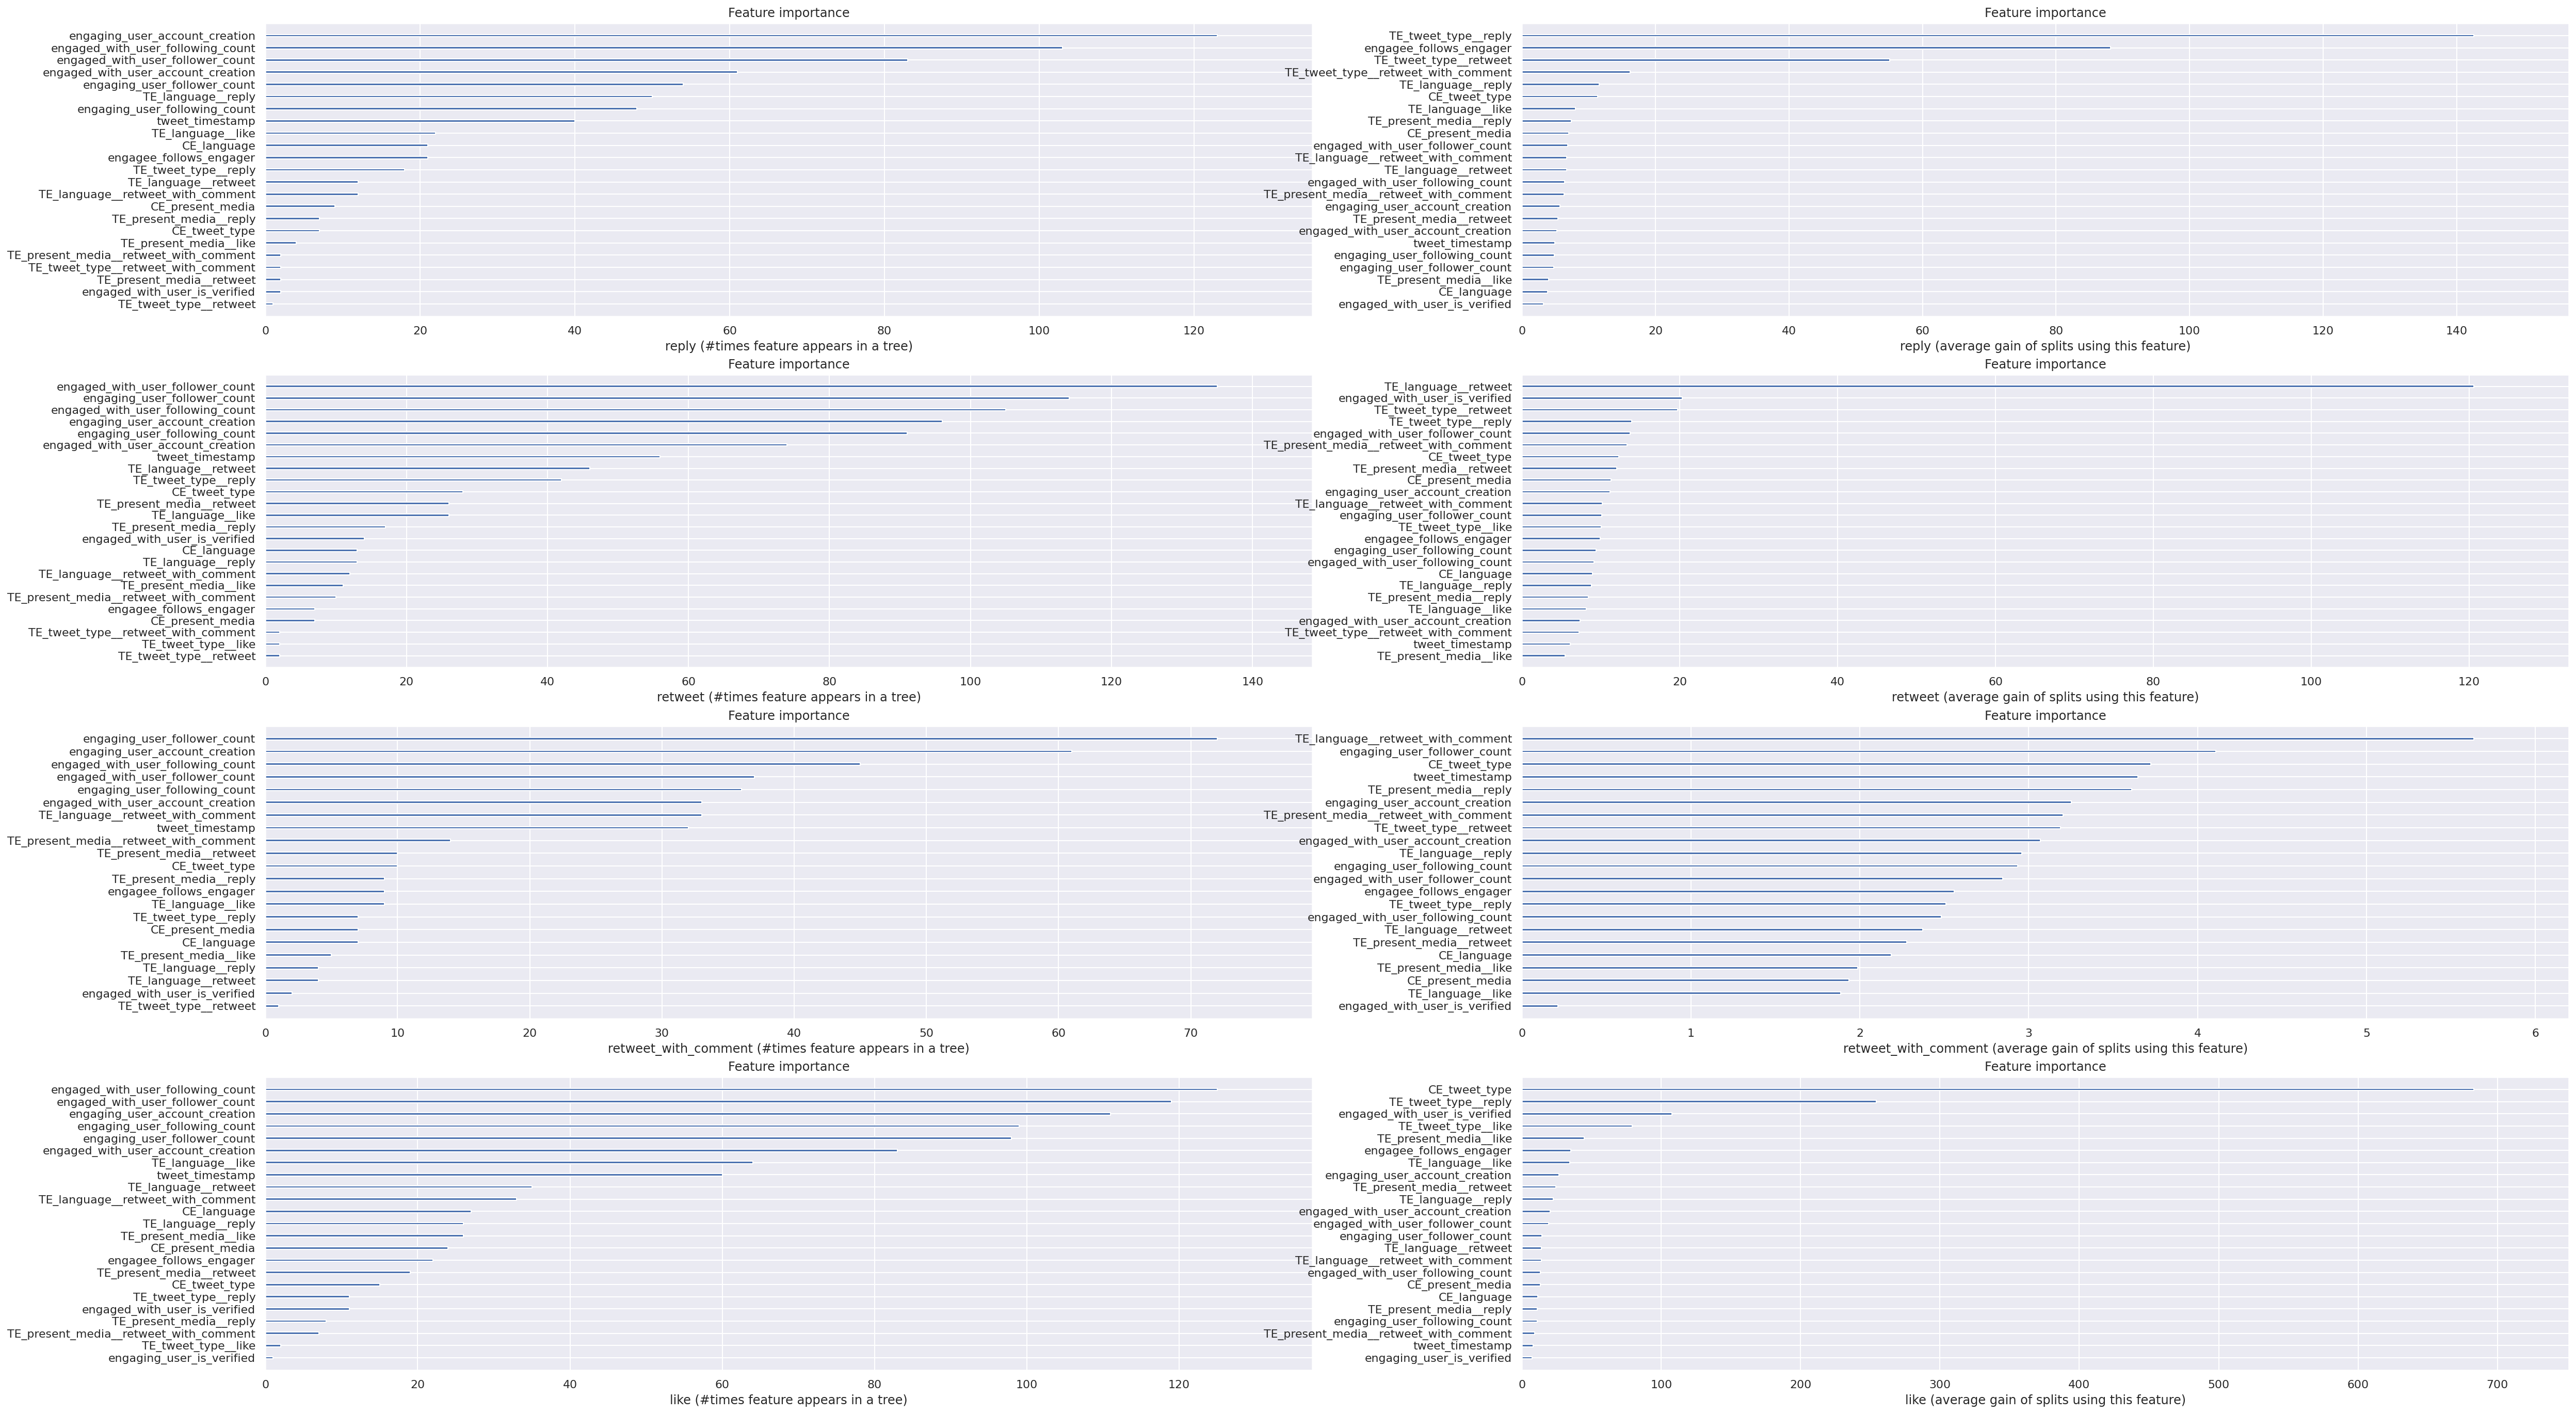

In [103]:
fig, axes = plt.subplots(4, 2, figsize=(40, 24))
for i, (name, booster) in enumerate(cv_models[-1].items()):
    ax = axes[i][0]
    xgb.plot_importance(booster, ax, importance_type='weight', xlabel=name+' (#times feature appears in a tree)', show_values=False, ylabel=None)
for i, (name, booster) in enumerate(cv_models[-1].items()):
    ax = axes[i][1]
    xgb.plot_importance(booster, ax, importance_type='gain', xlabel=name+' (average gain of splits using this feature)', show_values=False, ylabel=None)